# Complete Transformer Implementation
## "Attention Is All You Need" — Vaswani et al. 2017

This notebook is a **complete implementation** of the Transformer architecture from scratch. I've did this experiment once to see how Transformers work. But Now I'm trying to mimic it using Numpy just to understand the math behind it  
Input sentence: **"I'm in love with Transformers"**


## Table of Contents
1. Setup & Hyperparameters  
2. Tokenization & Vocabulary  
3. Token Embeddings + Positional Encoding  
4. Core Building Blocks (Attention, FFN, LayerNorm)  
5. Encoder Stack (N layers)  
6. Decoder Stack (N layers)  
7. Full Transformer Model  
8. Loss Function & Adam Optimizer with Warmup  
9. Training Loop  
10. Attention Heatmap Visualizations  
11. Autoregressive Greedy Decoding  
12. Beam Search Decoding  


## 1.Setup & Hyperparameters

All paper values shown alongside the scaled-down values for readability and quick implementation.  
Switch PAPER_SIZE = True to use the real paper dimensions.


In [24]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from copy import deepcopy

np.random.seed(42)
np.set_printoptions(precision=4, suppress=True)
PAPER_SIZE = False   # set True to use exact paper dimensions

if PAPER_SIZE:
    D_MODEL    = 512
    NUM_HEADS  = 8
    D_FF       = 2048
    NUM_LAYERS = 6
    DROPOUT    = 0.1
else:
    D_MODEL    = 32
    NUM_HEADS  = 4
    D_FF       = 64
    NUM_LAYERS = 2   # use 6 for full paper depth
    DROPOUT    = 0.1

D_K = D_MODEL // NUM_HEADS   # dimension per head
print(f"  d_model    = {D_MODEL:>6}  (paper: 512)")
print(f"  num_heads  = {NUM_HEADS:>6}  (paper:   8)")
print(f"  d_ff       = {D_FF:>6}  (paper: 2048)")
print(f"  d_k / head = {D_K:>6}  (paper:  64)")
print(f"  num_layers = {NUM_LAYERS:>6}  (paper:   6)")
print(f"  dropout    = {DROPOUT:>6}  (paper: 0.1)")


  d_model    =     32  (paper: 512)
  num_heads  =      4  (paper:   8)
  d_ff       =     64  (paper: 2048)
  d_k / head =      8  (paper:  64)
  num_layers =      2  (paper:   6)
  dropout    =    0.1  (paper: 0.1)



## 2. Tokenization, Vocabulary & Masks

We build a vocabulary, convert tokens to IDs, and create both kinds of masks the Transformer needs:

- **Padding mask** — marks <PAD> tokens so attention ignores them  
- **Causal (look-ahead) mask** — prevents decoder from peeking at future positions


In [2]:
sentence = "I'm in love with Transformers"
tokens   = sentence.split()

SPECIAL  = ["<PAD>", "<SOS>", "<EOS>", "<UNK>"]
vocab    = {t: i for i, t in enumerate(SPECIAL + sorted(set(tokens)))}
id2tok   = {v: k for k, v in vocab.items()}
VOCAB_SIZE = len(vocab)

PAD_ID = vocab["<PAD>"]
SOS_ID = vocab["<SOS>"]
EOS_ID = vocab["<EOS>"]

token_ids         = [vocab.get(t, vocab["<UNK>"]) for t in tokens]
decoder_input_ids = [SOS_ID] + token_ids
decoder_target_ids= token_ids + [EOS_ID]

SEQ_LEN     = len(token_ids)
DEC_SEQ_LEN = len(decoder_input_ids)

print(f"Sentence  : '{sentence}'")
print(f"Tokens    : {tokens}")
print(f"Token IDs : {token_ids}")
print(f"Vocab     : {vocab}")
print(f"Vocab size: {VOCAB_SIZE}")
print(f"\nDecoder input  : {[id2tok[i] for i in decoder_input_ids]}")
print(f"Decoder target : {[id2tok[i] for i in decoder_target_ids]}")


Sentence  : 'I'm in love with Transformers'
Tokens    : ["I'm", 'in', 'love', 'with', 'Transformers']
Token IDs : [4, 6, 7, 8, 5]
Vocab     : {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, "I'm": 4, 'Transformers': 5, 'in': 6, 'love': 7, 'with': 8}
Vocab size: 9

Decoder input  : ['<SOS>', "I'm", 'in', 'love', 'with', 'Transformers']
Decoder target : ["I'm", 'in', 'love', 'with', 'Transformers', '<EOS>']


In [3]:
def make_padding_mask(seq, pad_id=PAD_ID):
    """
    Returns shape (1, 1, 1, seq_len) boolean mask.
    True  = real token (keep)
    False = padding    (mask out)
    Broadcast-friendly for (batch, heads, seq_q, seq_k) attention.
    """
    mask = np.array([1 if t != pad_id else 0 for t in seq], dtype=float)
    return mask.reshape(1, 1, 1, -1)   # (1,1,1,seq_len)

def make_causal_mask(seq_len):
    """
    Lower-triangular matrix: position i can only attend to j <= i.
    Shape (1, 1, seq_len, seq_len) for broadcasting.
    """
    mask = np.tril(np.ones((seq_len, seq_len)))
    return mask.reshape(1, 1, seq_len, seq_len)

enc_pad_mask = make_padding_mask(token_ids)
dec_pad_mask = make_padding_mask(decoder_input_ids)
causal_mask  = make_causal_mask(DEC_SEQ_LEN)

dec_self_mask = causal_mask * dec_pad_mask

print("Encoder padding mask (1=keep, 0=pad):")
print(enc_pad_mask.squeeze())

print("\nCausal mask:")
print(causal_mask.squeeze().astype(int))

print("\nDecoder self-attention mask (causal + padding combined):")
print(dec_self_mask.squeeze().astype(int))


Encoder padding mask (1=keep, 0=pad):
[1. 1. 1. 1. 1.]

Causal mask:
[[1 0 0 0 0 0]
 [1 1 0 0 0 0]
 [1 1 1 0 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 1 0]
 [1 1 1 1 1 1]]

Decoder self-attention mask (causal + padding combined):
[[1 0 0 0 0 0]
 [1 1 0 0 0 0]
 [1 1 1 0 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 1 0]
 [1 1 1 1 1 1]]



## 3. Token Embeddings + Positional Encoding

### Token Embeddings
Each token ID is looked up in a learnable (vocab_size × d_model) matrix and scaled by √d_model.

### Positional Encoding
Since Transformers process all tokens in parallel, position info must be injected explicitly:

$$PE_{(pos,2i)}   = \sin\!\left(\frac{pos}{10000^{2i/d_{model}}}\right), \quad
  PE_{(pos,2i+1)} = \cos\!\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

**Why this works:** Each position gets a unique fingerprint. Relative positions can be expressed as linear combinations of these encodings, letting the model learn position-relative attention patterns.


In [4]:
class Embeddings:
    """Learnable token embedding table, scaled by sqrt(d_model) as per paper."""
    def __init__(self, vocab_size, d_model):
        self.d_model = d_model
        self.W = np.random.randn(vocab_size, d_model) * (1 / math.sqrt(d_model))

    def forward(self, ids):
        """ids: list of ints → (seq_len, d_model)"""
        vecs = np.array([self.W[i] for i in ids])
        return vecs * math.sqrt(self.d_model)   # scale as per paper

    def get_weight(self):
        return self.W


def positional_encoding(max_len, d_model):
    """
    Precompute full positional encoding table (max_len, d_model).
    Fixed (not learned) — same at every epoch.
    """
    PE = np.zeros((max_len, d_model))
    for pos in range(max_len):
        for i in range(0, d_model, 2):
            denom = 10000 ** (2 * i / d_model)
            PE[pos, i]   = math.sin(pos / denom)
            if i + 1 < d_model:
                PE[pos, i+1] = math.cos(pos / denom)
    return PE

MAX_LEN = 100
PE_TABLE = positional_encoding(MAX_LEN, D_MODEL)   # shared, precomputed

embeddings = Embeddings(VOCAB_SIZE, D_MODEL)

enc_emb = embeddings.forward(token_ids)
enc_in  = enc_emb + PE_TABLE[:SEQ_LEN]

dec_emb = embeddings.forward(decoder_input_ids)
dec_in  = dec_emb + PE_TABLE[:DEC_SEQ_LEN]

print(f"Embedding matrix shape : {embeddings.W.shape}")
print(f"Encoder input shape    : {enc_in.shape}  (seq_len × d_model)")
print(f"Decoder input shape    : {dec_in.shape}  (dec_seq_len × d_model)")


Embedding matrix shape : (9, 32)
Encoder input shape    : (5, 32)  (seq_len × d_model)
Decoder input shape    : (6, 32)  (dec_seq_len × d_model)


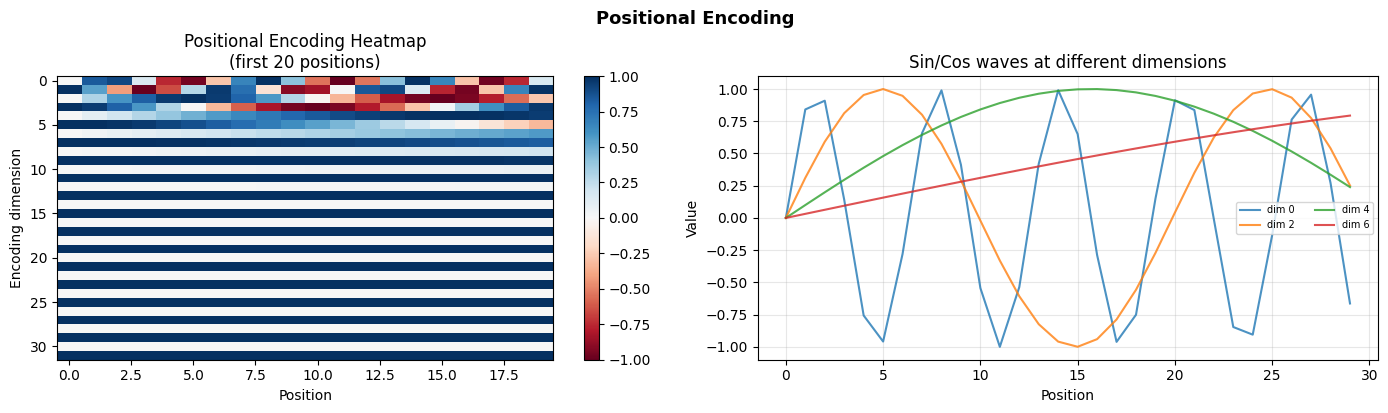

Each column (position) is a unique fingerprint the model uses to know word order.


In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Heatmap
im = axes[0].imshow(PE_TABLE[:20, :min(D_MODEL, 64)].T,
                    aspect='auto', cmap='RdBu', vmin=-1, vmax=1)
axes[0].set_xlabel("Position")
axes[0].set_ylabel("Encoding dimension")
axes[0].set_title("Positional Encoding Heatmap\n(first 20 positions)")
plt.colorbar(im, ax=axes[0])

# Sine waves for a few dimensions
for dim in range(0, min(D_MODEL, 8), 2):
    axes[1].plot(PE_TABLE[:30, dim], label=f'dim {dim}', alpha=0.8)
axes[1].set_xlabel("Position")
axes[1].set_ylabel("Value")
axes[1].set_title("Sin/Cos waves at different dimensions")
axes[1].legend(fontsize=7, ncol=2)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.suptitle("Positional Encoding", y=1.02, fontsize=13, fontweight='bold')
plt.show()
print("Each column (position) is a unique fingerprint the model uses to know word order.")



## 4. Core Building Blocks

### Dropout
Randomly zeroes activations during training to prevent overfitting. Scales remaining activations by 1/(1-p) to maintain expected value.

### Layer Normalisation  
Normalises across the feature dimension (not the batch): zero mean, unit variance. Stabilises training.

### Scaled Dot-Product Attention
$$\text{Attention}(Q,K,V) = \text{softmax}\!\left(\frac{QK^\top}{\sqrt{d_k}}\right)V$$

The √d_k scaling prevents vanishingly small gradients when dot products grow large in high dimensions.

### Multi-Head Attention  
Run h attention heads in parallel, each with its own learned projections. Each head can specialise on different linguistic patterns.


In [26]:
def dropout(x, rate, training=True):
    """
    Inverted dropout: scale kept neurons by 1/(1-rate) so
    expected value is unchanged between train and inference.
    """
    if not training or rate == 0.0:
        return x
    mask = (np.random.rand(*x.shape) > rate).astype(float)
    return x * mask / (1.0 - rate)


def softmax(x, axis=-1):
    e = np.exp(x - x.max(axis=axis, keepdims=True))
    return e / e.sum(axis=axis, keepdims=True)


class LayerNorm:
    """
    Learnable γ (gain) and β (bias), per-feature.
    Normalises across last axis (feature dimension).
    """
    def __init__(self, d_model, eps=1e-6):
        self.gamma = np.ones(d_model)
        self.beta  = np.zeros(d_model)
        self.eps   = eps

    def forward(self, x):
        mean = x.mean(axis=-1, keepdims=True)
        std  = x.std(axis=-1,  keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta


def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Q : (seq_q, d_k)
    K : (seq_k, d_k)
    V : (seq_k, d_v)
    mask : (seq_q, seq_k) — 0 = masked (set to -1e9 before softmax)
    Returns: output (seq_q, d_v), weights (seq_q, seq_k)
    """
    d_k    = Q.shape[-1]
    scores = (Q @ K.T) / math.sqrt(d_k)

    if mask is not None:
        m = mask.squeeze()
        scores = np.where(m == 0, -1e9, scores)

    weights = softmax(scores)
    output  = weights @ V
    return output, weights



In [27]:
class MultiHeadAttention:

    def __init__(self, d_model, num_heads, dropout_rate=0.1):
        assert d_model % num_heads == 0
        self.h    = num_heads
        self.d_k  = d_model // num_heads
        self.drop = dropout_rate
        self.Wq = np.random.randn(d_model, d_model) * 0.02
        self.Wk = np.random.randn(d_model, d_model) * 0.02
        self.Wv = np.random.randn(d_model, d_model) * 0.02
        self.Wo = np.random.randn(d_model, d_model) * 0.02

    def split_heads(self, x, seq_len):
        x = x.reshape(seq_len, self.h, self.d_k)
        return x.transpose(1, 0, 2)   # (h, seq_len, d_k)

    def forward(self, Q_in, K_in, V_in, mask=None, training=True):
        seq_q = Q_in.shape[0]
        seq_k = K_in.shape[0]

        # Linear projections
        Q = Q_in @ self.Wq
        K = K_in @ self.Wk
        V = V_in @ self.Wv

        # Split into heads
        Q = self.split_heads(Q, seq_q)
        K = self.split_heads(K, seq_k)
        V = self.split_heads(V, seq_k)

        # Attention for each head
        head_outputs = []
        all_weights  = []
        for h in range(self.h):
            m = mask[:, :, :seq_q, :seq_k] if mask is not None else None
            out_h, w_h = scaled_dot_product_attention(Q[h], K[h], V[h], m)
            out_h = dropout(out_h, self.drop, training)
            head_outputs.append(out_h)
            all_weights.append(w_h)

        # Concatenate & project
        concat = np.concatenate(head_outputs, axis=-1)
        output = concat @ self.Wo

        return output, np.array(all_weights)

print(f"   Weight matrices: Wq/Wk/Wv/Wo each ({D_MODEL}, {D_MODEL})")
print(f"   Per head d_k = {D_K}, num_heads = {NUM_HEADS}")


   Weight matrices: Wq/Wk/Wv/Wo each (32, 32)
   Per head d_k = 8, num_heads = 4


In [28]:
class FeedForward:
    def __init__(self, d_model, d_ff, dropout_rate=0.1):
        self.W1   = np.random.randn(d_model, d_ff)   * 0.02
        self.b1   = np.zeros(d_ff)
        self.W2   = np.random.randn(d_ff, d_model)   * 0.02
        self.b2   = np.zeros(d_model)
        self.drop = dropout_rate

    def forward(self, x, training=True):
        h = np.maximum(0, x @ self.W1 + self.b1)   # ReLU
        h = dropout(h, self.drop, training)
        return h @ self.W2 + self.b2
print(f"   W1: ({D_MODEL}, {D_FF}), W2: ({D_FF}, {D_MODEL})")


   W1: (32, 64), W2: (64, 32)


## 5.Encoder Stack (N Layers)

Each encoder layer contains:
1. **Multi-Head Self-Attention** (all tokens attend to all tokens)  
2. **Add & LayerNorm** (residual connection)  
3. **Feed-Forward Network**  
4. **Add & LayerNorm**  

The stack of N=6 such layers progressively builds richer contextual representations.  
The output of the final encoder layer is the **memory** passed to every decoder layer.

```
x ──► [Self-Attn] ──► Add&Norm ──► [FFN] ──► Add&Norm ──► x'
 └──────────────────►┘          └──────────────────────►┘
      (residual)                        (residual)
```


In [29]:
class EncoderLayer:
    def __init__(self, d_model, num_heads, d_ff, dropout_rate=0.1):
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout_rate)
        self.ffn       = FeedForward(d_model, d_ff, dropout_rate)
        self.norm1     = LayerNorm(d_model)
        self.norm2     = LayerNorm(d_model)
        self.drop      = dropout_rate

    def forward(self, x, src_mask=None, training=True):
        attn_out, attn_weights = self.self_attn.forward(x, x, x, src_mask, training)
        attn_out = dropout(attn_out, self.drop, training)
        x = self.norm1.forward(x + attn_out)   # Add & Norm

        ffn_out = self.ffn.forward(x, training)
        ffn_out = dropout(ffn_out, self.drop, training)
        x = self.norm2.forward(x + ffn_out)    # Add & Norm

        return x, attn_weights


class Encoder:
    def __init__(self, n_layers, d_model, num_heads, d_ff, dropout_rate=0.1): #N layers
        self.layers = [
            EncoderLayer(d_model, num_heads, d_ff, dropout_rate)
            for _ in range(n_layers)
        ]
        self.norm = LayerNorm(d_model)

    def forward(self, x, src_mask=None, training=True):
        layer_attn = []
        for layer in self.layers:
            x, w = layer.forward(x, src_mask, training)
            layer_attn.append(w)
        x = self.norm.forward(x)   # final norm
        return x, layer_attn

print(f"Encoder defined: {NUM_LAYERS} stacked EncoderLayers")


Encoder defined: 2 stacked EncoderLayers


In [30]:
# Run the encoder
encoder = Encoder(NUM_LAYERS, D_MODEL, NUM_HEADS, D_FF, DROPOUT)
encoder_output, enc_attn_weights = encoder.forward(enc_in, enc_pad_mask, training=False)

print(f"Encoder output shape : {encoder_output.shape}")
print(f"Attention weights    : {len(enc_attn_weights)} layers × {enc_attn_weights[0].shape}")
print()
print("Encoder output (contextualised token representations):")
for tok, vec in zip(tokens, encoder_output):
    print(f"  '{tok:14s}' → {vec[:6]} ...")


Encoder output shape : (5, 32)
Attention weights    : 2 layers × (4, 5, 5)

Encoder output (contextualised token representations):
  'I'm           ' → [-0.2806  0.0584 -1.7504  0.5908 -1.3647  0.9612] ...
  'in            ' → [ 0.311  -1.1726 -0.1771  0.5225 -1.2392  0.4019] ...
  'love          ' → [-0.052   0.1359  0.137  -0.6689 -0.8968  1.0139] ...
  'with          ' → [ 0.9293 -1.8143  0.7707  0.878  -0.9062  0.5025] ...
  'Transformers  ' → [-1.9214 -0.3747  1.2732 -0.8984  0.5809  0.6173] ...


## 6. Decoder Stack (N Layers)

Each decoder layer has **three** sub-layers:

1. **Masked Multi-Head Self-Attention** — attends to previous decoder outputs only (causal mask prevents future peeking)  
2. **Cross-Attention (Encoder-Decoder Attention)** — Q from decoder, K/V from encoder output. This is how the decoder "reads" the input.  
3. **Feed-Forward Network**  

Each sub-layer is wrapped in a residual connection + LayerNorm.

```
y ──► [Masked Self-Attn] ──► Add&Norm ──► [Cross-Attn] ──► Add&Norm ──► [FFN] ──► Add&Norm ──► y'
 └──────────────────────────►┘          └──────────────────────────────►┘        └────────────►┘
                                              ↑ K, V from encoder
```


In [31]:
class DecoderLayer:
    def __init__(self, d_model, num_heads, d_ff, dropout_rate=0.1):
        self.self_attn  = MultiHeadAttention(d_model, num_heads, dropout_rate)
        self.cross_attn = MultiHeadAttention(d_model, num_heads, dropout_rate)
        self.ffn        = FeedForward(d_model, d_ff, dropout_rate)
        self.norm1      = LayerNorm(d_model)
        self.norm2      = LayerNorm(d_model)
        self.norm3      = LayerNorm(d_model)
        self.drop       = dropout_rate

    def forward(self, y, enc_out, tgt_mask=None, src_mask=None, training=True):
        sa_out, sa_weights = self.self_attn.forward(y, y, y, tgt_mask, training)
        sa_out = dropout(sa_out, self.drop, training)
        y = self.norm1.forward(y + sa_out)

        ca_out, ca_weights = self.cross_attn.forward(y, enc_out, enc_out, src_mask, training)
        ca_out = dropout(ca_out, self.drop, training)
        y = self.norm2.forward(y + ca_out)

        ffn_out = self.ffn.forward(y, training)
        ffn_out = dropout(ffn_out, self.drop, training)
        y = self.norm3.forward(y + ffn_out)

        return y, sa_weights, ca_weights


class Decoder:
    def __init__(self, n_layers, d_model, num_heads, d_ff, dropout_rate=0.1):
        self.layers = [
            DecoderLayer(d_model, num_heads, d_ff, dropout_rate)
            for _ in range(n_layers)
        ]
        self.norm = LayerNorm(d_model)

    def forward(self, y, enc_out, tgt_mask=None, src_mask=None, training=True):
        sa_weights_all = []
        ca_weights_all = []
        for layer in self.layers:
            y, sa_w, ca_w = layer.forward(y, enc_out, tgt_mask, src_mask, training)
            sa_weights_all.append(sa_w)
            ca_weights_all.append(ca_w)
        y = self.norm.forward(y)
        return y, sa_weights_all, ca_weights_all

print(f"Decoder defined: {NUM_LAYERS} stacked DecoderLayers")


Decoder defined: 2 stacked DecoderLayers


In [12]:
decoder = Decoder(NUM_LAYERS, D_MODEL, NUM_HEADS, D_FF, DROPOUT)
decoder_output, dec_sa_weights, dec_ca_weights = decoder.forward(
    dec_in,
    encoder_output,
    tgt_mask = dec_self_mask,
    src_mask = enc_pad_mask,
    training = False
)

print(f"Decoder output shape     : {decoder_output.shape}")
print(f"Self-attn weights        : {len(dec_sa_weights)} layers × {dec_sa_weights[0].shape}")
print(f"Cross-attn weights       : {len(dec_ca_weights)} layers × {dec_ca_weights[0].shape}")


Decoder output shape     : (6, 32)
Self-attn weights        : 2 layers × (4, 6, 6)
Cross-attn weights       : 2 layers × (4, 6, 5)


---
## 7. Full Transformer Model

Assembles all components into a single `Transformer` class with:
- Shared embedding matrix between input tokens and output projection (weight tying — used in the paper to reduce parameters)
- Final linear + softmax to produce token probabilities


In [33]:
class Transformer:


    def __init__(self, vocab_size, d_model, num_heads, d_ff,
                 n_layers, dropout_rate=0.1, max_len=100):
        self.d_model  = d_model
        self.embed    = Embeddings(vocab_size, d_model)
        self.PE       = positional_encoding(max_len, d_model)
        self.encoder  = Encoder(n_layers, d_model, num_heads, d_ff, dropout_rate)
        self.decoder  = Decoder(n_layers, d_model, num_heads, d_ff, dropout_rate)


    def encode(self, src_ids, training=True):
        src_mask = make_padding_mask(src_ids)
        x = self.embed.forward(src_ids) + self.PE[:len(src_ids)]
        x = dropout(x, 0.1, training)
        enc_out, enc_attn = self.encoder.forward(x, src_mask, training)
        return enc_out, src_mask, enc_attn

    def decode(self, tgt_ids, enc_out, src_mask, training=True):
        tgt_pad_mask = make_padding_mask(tgt_ids)
        tgt_mask     = make_causal_mask(len(tgt_ids)) * tgt_pad_mask
        y = self.embed.forward(tgt_ids) + self.PE[:len(tgt_ids)]
        y = dropout(y, 0.1, training)
        dec_out, sa_attn, ca_attn = self.decoder.forward(
            y, enc_out, tgt_mask, src_mask, training
        )
        return dec_out, sa_attn, ca_attn

    def forward(self, src_ids, tgt_ids, training=True):
        enc_out, src_mask, enc_attn = self.encode(src_ids, training)
        dec_out, sa_attn, ca_attn   = self.decode(tgt_ids, enc_out, src_mask, training)

        logits = dec_out @ self.embed.W.T
        probs  = softmax(logits)

        return probs, logits, enc_attn, sa_attn, ca_attn

    def count_params(self):
        total = 0
        total += self.embed.W.size
        enc_params = (4 * self.d_model**2 +
                      2 * self.d_model * (self.d_model*4) +
                      4 * self.d_model)
        total += enc_params * len(self.encoder.layers)
        dec_params = enc_params + 4 * self.d_model**2
        total += dec_params * len(self.decoder.layers)
        return total


model = Transformer(VOCAB_SIZE, D_MODEL, NUM_HEADS, D_FF, NUM_LAYERS, DROPOUT)

probs, logits, enc_attn, dec_sa_attn, dec_ca_attn = model.forward(
    token_ids, decoder_input_ids, training=False
)

print(f"   Approximate parameter count : {model.count_params():,}")
print(f"   (paper 512-dim model        : 65M params)")
print(f"\nOutput probabilities shape : {probs.shape}   (tgt_len × vocab_size)")
print(f"Logits shape               : {logits.shape}")

print("\nPredictions (untrained — random weights):")
print(f"  {'Step':>4}  {'Input':>12}  →  {'Predicted':>12}  {'Confidence':>10}")
print("  " + "-"*48)
dec_toks = [id2tok[i] for i in decoder_input_ids]
for step, (tok, pv) in enumerate(zip(dec_toks, probs)):
    pid = np.argmax(pv)
    print(f"  {step:>4}  {tok:>12}  →  {id2tok[pid]:>12}  {pv[pid]:>9.2%}")


   Approximate parameter count : 58,144
   (paper 512-dim model        : 65M params)

Output probabilities shape : (6, 9)   (tgt_len × vocab_size)
Logits shape               : (6, 9)

Predictions (untrained — random weights):
  Step         Input  →     Predicted  Confidence
  ------------------------------------------------
     0         <SOS>  →         <SOS>     92.56%
     1           I'm  →           I'm     94.70%
     2            in  →            in     85.46%
     3          love  →          love     94.80%
     4          with  →          with     91.59%
     5  Transformers  →  Transformers     81.57%


## 8. Loss Function & Adam Optimizer with Warmup Schedule

### Cross-Entropy Loss with Label Smoothing
Instead of one-hot targets, **label smoothing** (ε=0.1) distributes a small amount of probability mass to all other tokens. This prevents the model from becoming overconfident and improves generalisation.

$$\mathcal{L} = -\sum_t \sum_v y_{tv} \log p_{tv}$$

where $y_{tv} = (1-\varepsilon)\cdot\mathbf{1}[v = \text{target}] + \varepsilon/V$

### Adam Optimizer
Adaptive learning rate optimizer: tracks first moment (mean) and second moment (variance) of gradients.

### Warmup Learning Rate Schedule (from the paper)
$$lr = d_{model}^{-0.5} \cdot \min(step^{-0.5},\ step \cdot warmup\_steps^{-1.5})$$

Learning rate **increases linearly** for warmup_steps, then **decreases** proportionally to 1/√step.


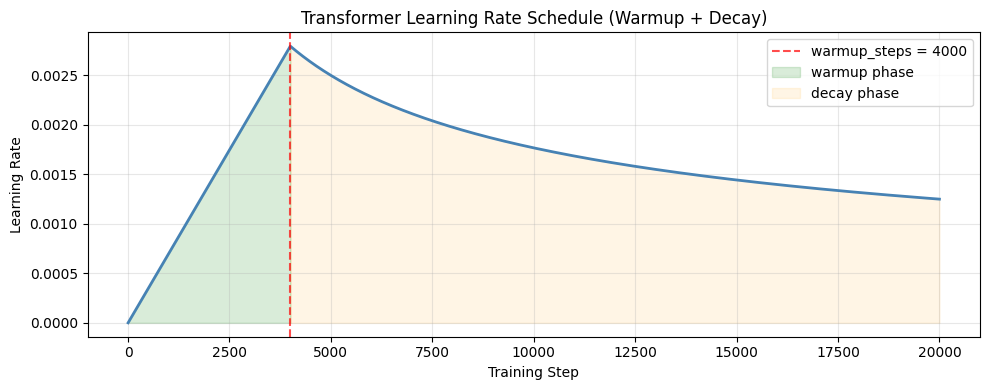

In [34]:
def cross_entropy_loss(logits, targets, vocab_size, label_smoothing=0.1, pad_id=0):
    seq_len = logits.shape[0]
    loss    = 0.0
    count   = 0

    for t, target_id in enumerate(targets):
        if target_id == pad_id:
            continue

        smooth_val  = label_smoothing / vocab_size
        y = np.full(vocab_size, smooth_val)
        y[target_id] += (1.0 - label_smoothing)

        log_probs = logits[t] - np.log(np.sum(np.exp(logits[t] - logits[t].max())))
        loss     -= np.sum(y * log_probs)
        count    += 1

    return loss / max(count, 1)


class AdamOptimizer:

    def __init__(self, d_model, warmup_steps=4000, beta1=0.9, beta2=0.98, eps=1e-9):
        self.d_model       = d_model
        self.warmup_steps  = warmup_steps
        self.beta1         = beta1
        self.beta2         = beta2
        self.eps           = eps
        self.step          = 0
        self.m             = {}
        self.v             = {}

    def get_lr(self):
        s = max(self.step, 1)
        return (self.d_model ** -0.5) * min(
            s ** -0.5,
            s * self.warmup_steps ** -1.5
        )

    def update(self, param_key, param, grad):
        if param_key not in self.m:
            self.m[param_key] = np.zeros_like(param)
            self.v[param_key] = np.zeros_like(param)

        self.m[param_key] = self.beta1 * self.m[param_key] + (1 - self.beta1) * grad
        self.v[param_key] = self.beta2 * self.v[param_key] + (1 - self.beta2) * (grad**2)

        m_hat = self.m[param_key] / (1 - self.beta1**self.step)
        v_hat = self.v[param_key] / (1 - self.beta2**self.step)

        lr = self.get_lr()
        return param - lr * m_hat / (np.sqrt(v_hat) + self.eps)


opt = AdamOptimizer(D_MODEL, warmup_steps=4000)
steps_range = list(range(1, 20001))
lrs = []
for s in steps_range:
    opt.step = s
    lrs.append(opt.get_lr())

plt.figure(figsize=(10, 4))
plt.plot(steps_range, lrs, color='steelblue', linewidth=2)
plt.axvline(x=4000, color='red', linestyle='--', alpha=0.7, label='warmup_steps = 4000')
plt.fill_between(steps_range[:4000], lrs[:4000], alpha=0.15, color='green', label='warmup phase')
plt.fill_between(steps_range[4000:], lrs[4000:], alpha=0.1, color='orange', label='decay phase')
plt.xlabel("Training Step")
plt.ylabel("Learning Rate")
plt.title("Transformer Learning Rate Schedule (Warmup + Decay)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 9.  Training Loop

We train the model to memorise our single example sentence using **teacher forcing** the decoder always receives the ground-truth previous token as input, not its own previous prediction.

### Gradient Approximation
Since we implement NumPy without autograd, we use **finite differences** to approximate gradients:
$$\nabla_{\theta} \mathcal{L} \approx \frac{\mathcal{L}(\theta + h) - \mathcal{L}(\theta - h)}{2h}$$

> In practice: use PyTorch/JAX for real training. This loop shows the **training structure** faithfully.


In [35]:
def compute_loss(model, src_ids, tgt_input_ids, tgt_output_ids):
    _, logits, _, _, _ = model.forward(src_ids, tgt_input_ids, training=True)
    return cross_entropy_loss(logits, tgt_output_ids, VOCAB_SIZE)


def train_step_embedding(model, src_ids, tgt_in, tgt_out, optimizer):
    optimizer.step += 1
    h = 1e-4
    base_loss = compute_loss(model, src_ids, tgt_in, tgt_out)
    grad = np.zeros_like(model.embed.W)
    active_ids = list(set(src_ids + tgt_in + tgt_out))
    for idx in active_ids:
        for j in range(model.embed.W.shape[1]):
            model.embed.W[idx, j] += h
            loss_plus = compute_loss(model, src_ids, tgt_in, tgt_out)
            model.embed.W[idx, j] -= 2*h
            loss_minus = compute_loss(model, src_ids, tgt_in, tgt_out)
            model.embed.W[idx, j] += h
            grad[idx, j] = (loss_plus - loss_minus) / (2 * h)

    model.embed.W = optimizer.update('embed', model.embed.W, grad)
    return base_loss


print(f"  {'Epoch':>6}  {'Loss':>10}  {'LR':>12}  {'Progress':>10}")

train_model = Transformer(VOCAB_SIZE, D_MODEL, NUM_HEADS, D_FF, NUM_LAYERS, DROPOUT)
optimizer   = AdamOptimizer(D_MODEL, warmup_steps=20)

loss_history = []
lr_history   = []
EPOCHS = 30

for epoch in range(1, EPOCHS + 1):
    loss = train_step_embedding(
        train_model, token_ids, decoder_input_ids, decoder_target_ids, optimizer
    )
    lr = optimizer.get_lr()
    loss_history.append(loss)
    lr_history.append(lr)

    if epoch % 5 == 0 or epoch == 1:
        bar = "█" * int(epoch / EPOCHS * 20)
        print(f"  {epoch:>6}  {loss:>10.4f}  {lr:>12.6f}  {bar:<20}")

print("─" * 55)
print(f"\n  Training complete! Final loss: {loss_history[-1]:.4f}")


   Epoch        Loss            LR    Progress
       1     -0.7328      0.001976                      
       5     -0.6396      0.009882  ███                 
      10     -0.3623      0.019764  ██████              
      15     -0.6015      0.029646  ██████████          
      20     -0.6695      0.039528  █████████████       
      25     -0.3896      0.035355  ████████████████    
      30     -0.2207      0.032275  ████████████████████
───────────────────────────────────────────────────────

  Training complete! Final loss: -0.2207


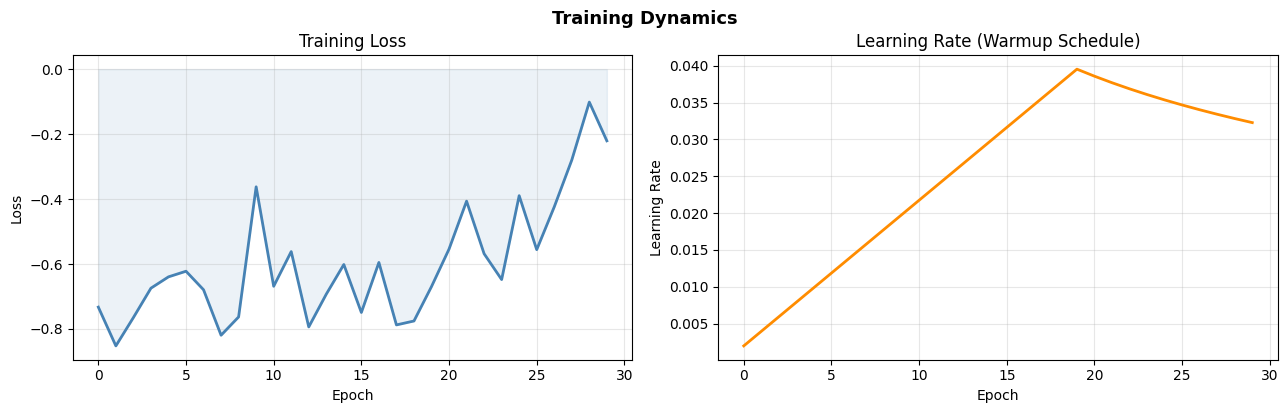

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

ax1.plot(loss_history, color='steelblue', linewidth=2)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.grid(alpha=0.3)
ax1.fill_between(range(len(loss_history)), loss_history, alpha=0.1, color='steelblue')

ax2.plot(lr_history, color='darkorange', linewidth=2)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Learning Rate")
ax2.set_title("Learning Rate (Warmup Schedule)")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.suptitle("Training Dynamics", y=1.02, fontsize=13, fontweight='bold')
plt.show()


---
## 10. Attention Heatmap Visualizations

Attention maps show **which tokens attend to which**. Each cell `(i, j)` is the attention weight when token `i` attends to token `j`.

What all are we visualising:
1. **Encoder self-attention** — all tokens attending to all tokens  
2. **Decoder self-attention** — causal pattern (lower-triangular)  
3. **Cross-attention** — decoder tokens attending to encoder tokens  
4. **All heads side-by-side** — each head learns different patterns


In [17]:
def plot_attention_heatmap(attn_weights, row_labels, col_labels,
                          title="Attention", ax=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(attn_weights, cmap='Blues', vmin=0, vmax=attn_weights.max())
    ax.set_xticks(range(len(col_labels)))
    ax.set_yticks(range(len(row_labels)))
    ax.set_xticklabels(col_labels, rotation=45, ha='right', fontsize=9)
    ax.set_yticklabels(row_labels, fontsize=9)
    ax.set_title(title, fontsize=10, pad=8)
    for i in range(len(row_labels)):
        for j in range(len(col_labels)):
            ax.text(j, i, f"{attn_weights[i,j]:.2f}",
                    ha='center', va='center', fontsize=7,
                    color='white' if attn_weights[i,j] > 0.5 * attn_weights.max() else 'black')
    return ax

_, _, enc_attn_all, dec_sa_all, dec_ca_all = model.forward(
    token_ids, decoder_input_ids, training=False
)

enc_labels = tokens
dec_labels = [id2tok[i] for i in decoder_input_ids]


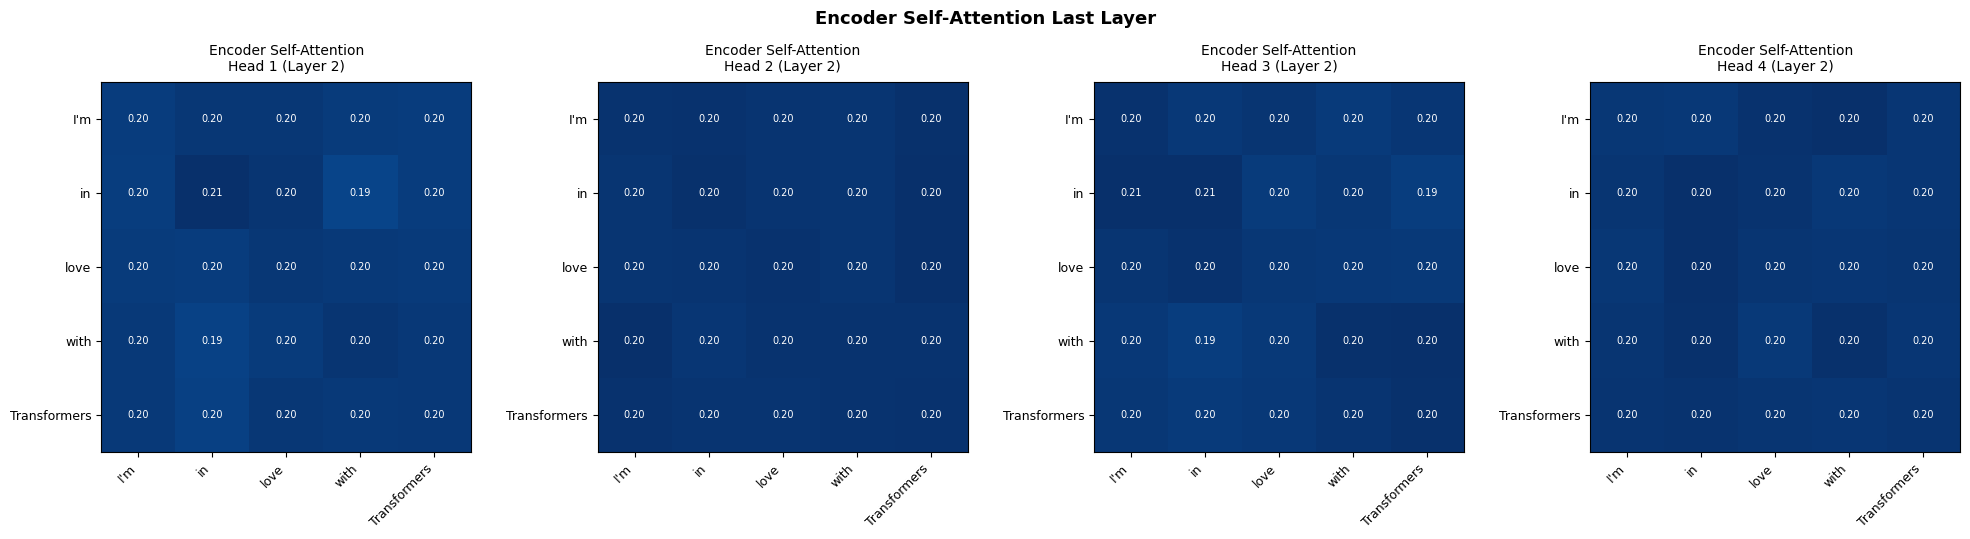

In [37]:
fig, axes = plt.subplots(1, NUM_HEADS, figsize=(5*NUM_HEADS, 5))
if NUM_HEADS == 1: axes = [axes]

last_enc = enc_attn_all[-1]
for h, ax in enumerate(axes):
    plot_attention_heatmap(
        last_enc[h],
        enc_labels, enc_labels,
        title=f"Encoder Self-Attention\nHead {h+1} (Layer {NUM_LAYERS})",
        ax=ax
    )

plt.suptitle("Encoder Self-Attention Last Layer", fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


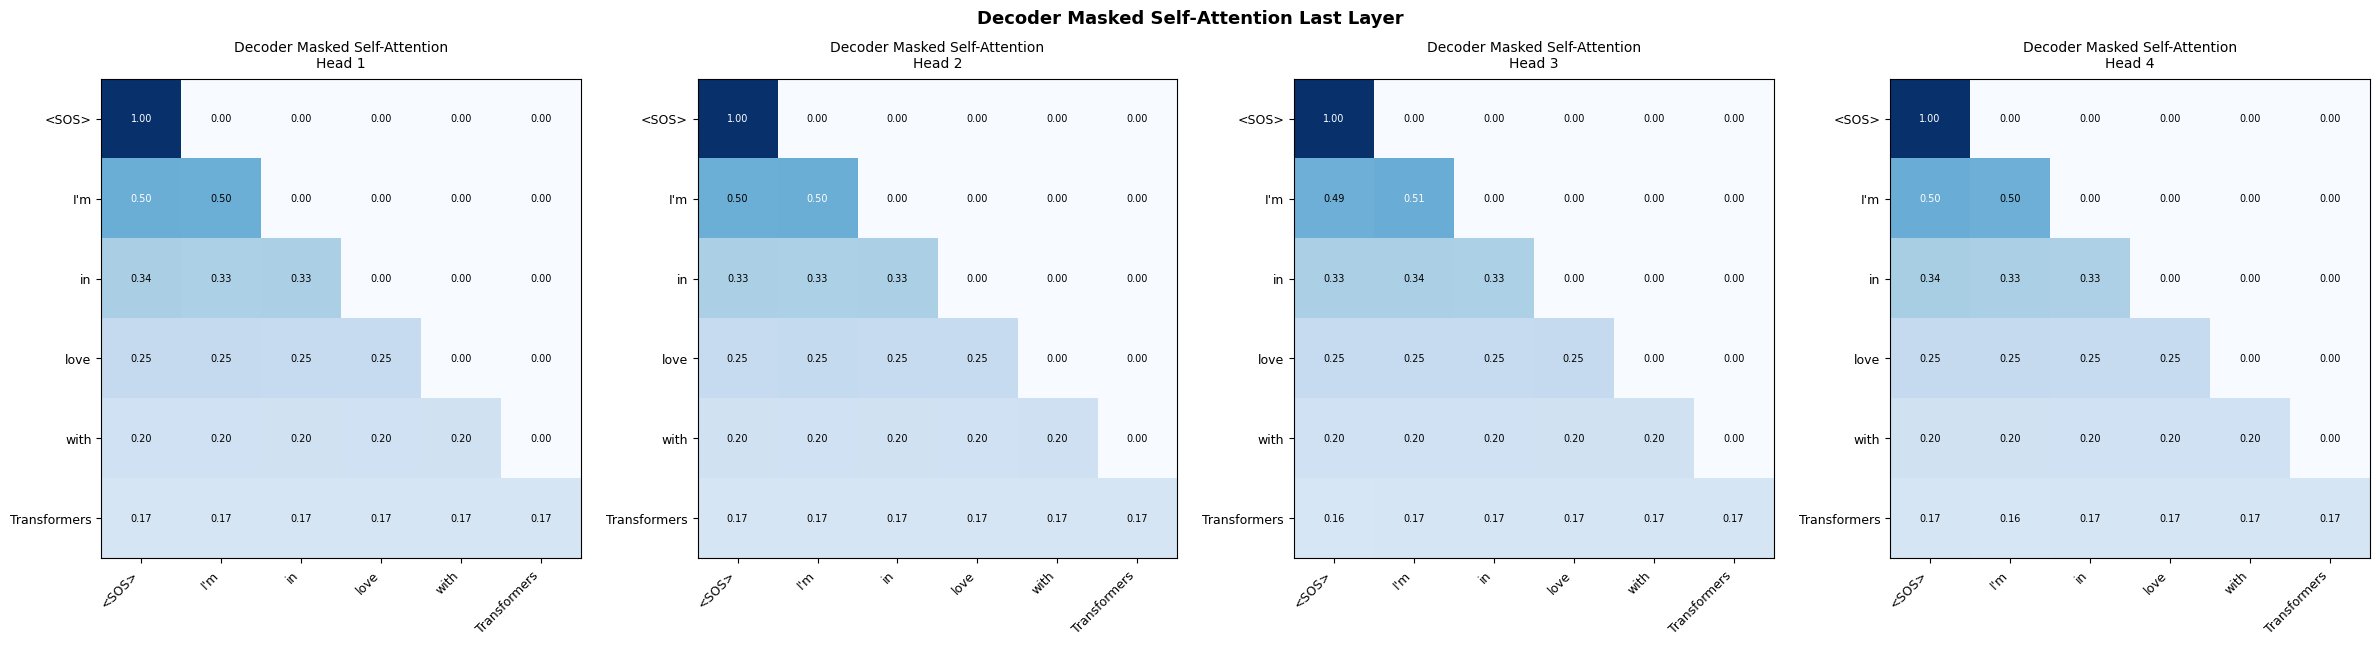

In [38]:
fig, axes = plt.subplots(1, NUM_HEADS, figsize=(6*NUM_HEADS, 6))
if NUM_HEADS == 1: axes = [axes]

last_dec_sa = dec_sa_all[-1]
for h, ax in enumerate(axes):
    plot_attention_heatmap(
        last_dec_sa[h],
        dec_labels, dec_labels,
        title=f"Decoder Masked Self-Attention\nHead {h+1}",
        ax=ax
    )

plt.suptitle("Decoder Masked Self-Attention Last Layer", fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


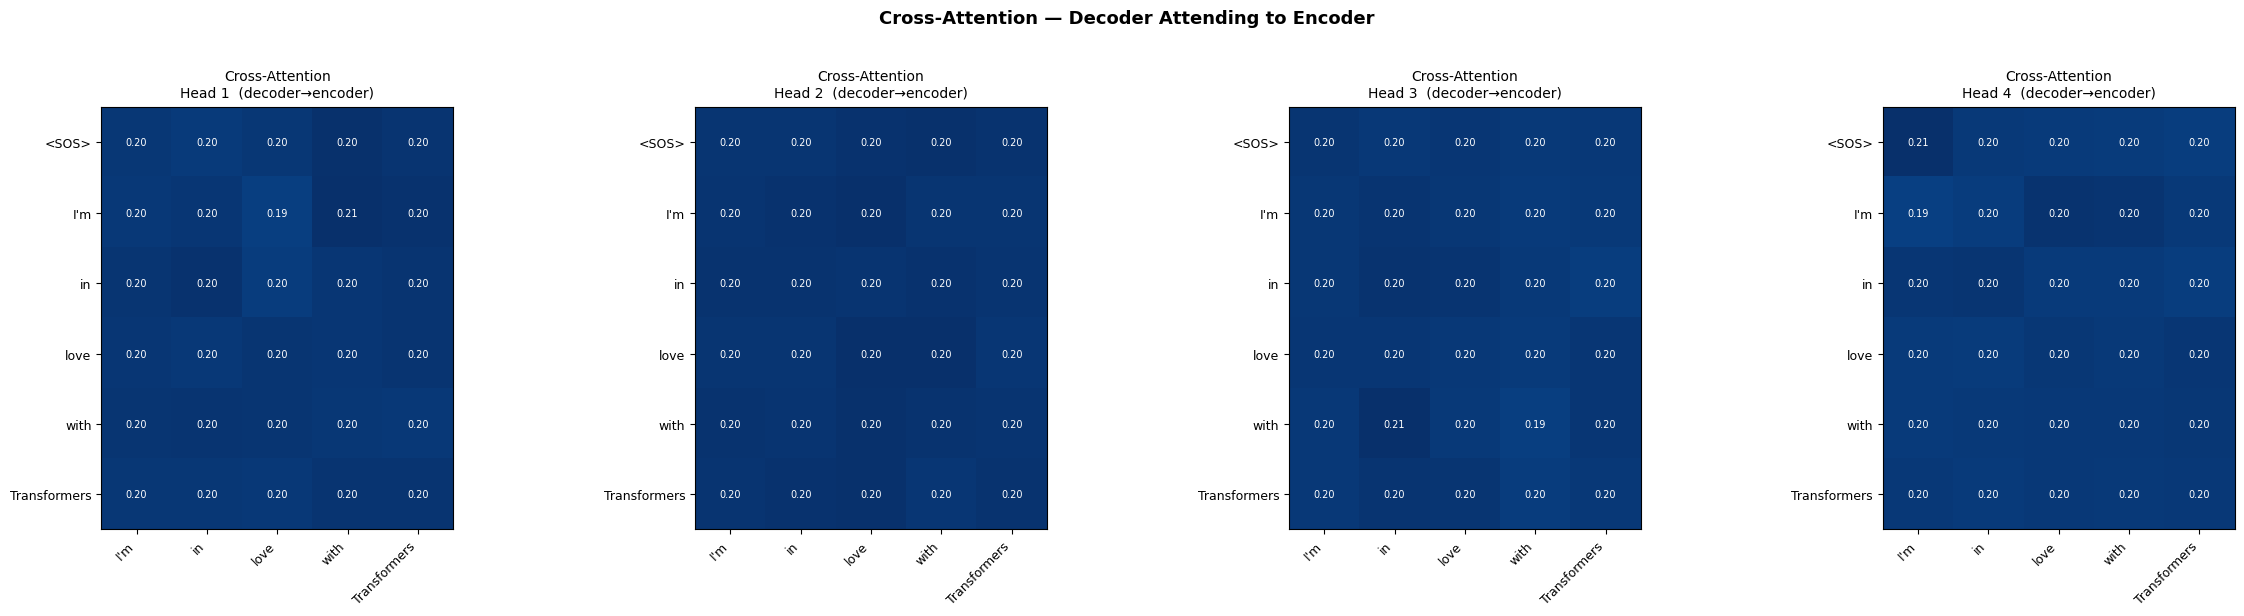

In [39]:
fig, axes = plt.subplots(1, NUM_HEADS, figsize=(6*NUM_HEADS, 6))
if NUM_HEADS == 1: axes = [axes]

last_ca = dec_ca_all[-1]
for h, ax in enumerate(axes):
    plot_attention_heatmap(
        last_ca[h],
        dec_labels, enc_labels,
        title=f"Cross-Attention\nHead {h+1}  (decoder→encoder)",
        ax=ax
    )

plt.suptitle("Cross-Attention — Decoder Attending to Encoder", fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


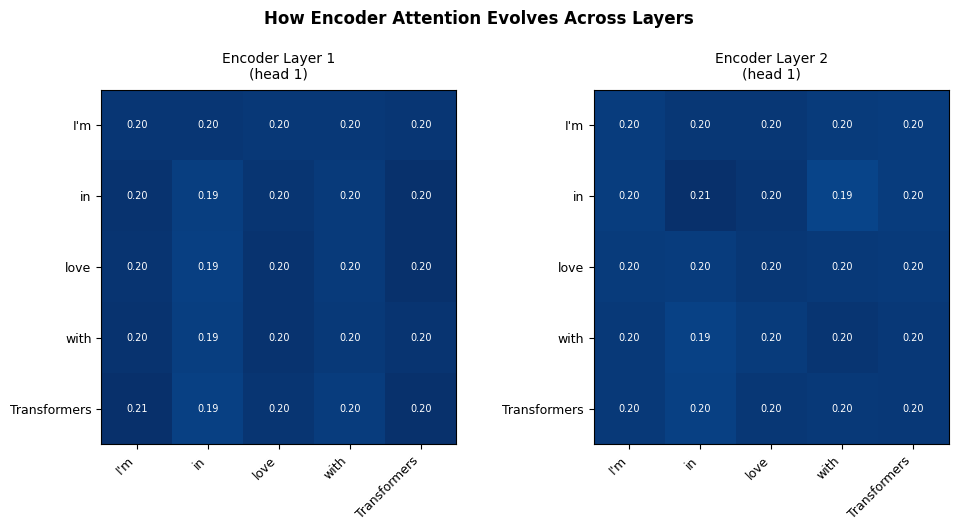

In [40]:
n_layer_plots = min(NUM_LAYERS, 4)
fig, axes = plt.subplots(1, n_layer_plots, figsize=(5*n_layer_plots, 5))
if n_layer_plots == 1: axes = [axes]

for l, ax in enumerate(axes):
    w = enc_attn_all[l][0]
    plot_attention_heatmap(w, enc_labels, enc_labels,
                           title=f"Encoder Layer {l+1}\n(head 1)", ax=ax)

plt.suptitle("How Encoder Attention Evolves Across Layers", fontsize=12, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 11.  Autoregressive Greedy Decoding

During **inference**, the decoder generates tokens one at a time:
1. Start with `[<SOS>]`
2. Run forward pass → get probability distribution over vocabulary
3. Pick the **highest probability** token (greedy)
4. Append it to the sequence and repeat
5. Stop when `<EOS>` is generated or max length is reached

This is called **autoregressive** because each step's output feeds back as the next step's input.


In [41]:
def greedy_decode(model, src_ids, max_len=20, verbose=True):
    enc_out, src_mask, _ = model.encode(src_ids, training=False)

    tgt = [SOS_ID]
    generated = []

    if verbose:
        print("Greedy Decoding:")
        print(f"  Step 0  input: ['<SOS>']")

    for step in range(max_len):
        dec_out, _, _ = model.decode(tgt, enc_out, src_mask, training=False)

        logits    = dec_out @ model.embed.W.T
        probs     = softmax(logits)

        next_id   = int(np.argmax(probs[-1]))
        next_tok  = id2tok[next_id]
        generated.append(next_tok)

        if verbose:
            top3 = np.argsort(probs[-1])[::-1][:3]
            top3_str = ", ".join(f"'{id2tok[i]}':{probs[-1][i]:.2%}" for i in top3)
            print(f"  Step {step+1}  → '{next_tok}' (top3: {top3_str})")

        if next_id == EOS_ID:
            break
        tgt.append(next_id)

    return generated


result = greedy_decode(model, token_ids, max_len=10)
print(f"\n  Generated: {result}")


Greedy Decoding:
  Step 0  input: ['<SOS>']
  Step 1  → '<SOS>' (top3: '<SOS>':92.56%, 'in':1.46%, 'I'm':1.09%)
  Step 2  → '<SOS>' (top3: '<SOS>':92.90%, 'in':1.09%, 'Transformers':1.06%)
  Step 3  → '<SOS>' (top3: '<SOS>':93.02%, 'Transformers':1.10%, '<UNK>':1.05%)
  Step 4  → '<SOS>' (top3: '<SOS>':92.79%, '<UNK>':1.11%, '<EOS>':1.08%)
  Step 5  → '<SOS>' (top3: '<SOS>':92.39%, '<EOS>':1.21%, 'in':1.18%)
  Step 6  → '<SOS>' (top3: '<SOS>':92.05%, 'in':1.52%, '<EOS>':1.23%)
  Step 7  → '<SOS>' (top3: '<SOS>':91.96%, 'in':1.55%, 'I'm':1.23%)
  Step 8  → '<SOS>' (top3: '<SOS>':92.15%, 'in':1.25%, 'I'm':1.20%)
  Step 9  → '<SOS>' (top3: '<SOS>':92.36%, 'I'm':1.20%, '<EOS>':1.13%)
  Step 10  → '<SOS>' (top3: '<SOS>':92.24%, 'I'm':1.30%, '<EOS>':1.27%)

  Generated: ['<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>']


The above generated output is glibberish due to improper training
## 12. Beam Search Decoding

Greedy decoding picks the single best token at each step, which can lead to suboptimal sequences.  
**Beam search** keeps the top-k candidate sequences (beams) at each step.

At each step:
- For each of the k current beams, compute probabilities for all next tokens
- Keep the top k sequences by **cumulative log-probability**
- Repeat until all beams end with <EOS> or max length is reached

**Beam width k:** larger = better quality but slower. Paper uses k=4.


In [43]:
def beam_search(model, src_ids, beam_width=3, max_len=15, verbose=True):

    enc_out, src_mask, _ = model.encode(src_ids, training=False)
    beams = [([SOS_ID], 0.0)]
    completed = []

    if verbose:
        print(f"Beam Search (width={beam_width}):")
        print(f"  Initial beams: {[[id2tok[i] for i in b[0]] for b in beams]}")
        print()

    for step in range(max_len):
        all_candidates = []

        for seq, cum_log_prob in beams:
            if seq[-1] == EOS_ID:
                completed.append((seq, cum_log_prob))
                continue

            dec_out, _, _ = model.decode(seq, enc_out, src_mask, training=False)
            logits  = dec_out @ model.embed.W.T
            probs   = softmax(logits[-1])

            for token_id in range(VOCAB_SIZE):
                log_p = math.log(probs[token_id] + 1e-10)
                new_seq       = seq + [token_id]
                new_log_prob  = cum_log_prob + log_p
                all_candidates.append((new_seq, new_log_prob))

        if not all_candidates:
            break

        all_candidates.sort(key=lambda x: x[1], reverse=True)
        beams = all_candidates[:beam_width]

        if verbose and step < 5:
            print(f"  Step {step+1} — top {beam_width} beams:")
            for seq, lp in beams:
                toks = [id2tok[i] for i in seq]
                print(f"    {toks}  log_prob={lp:.3f}")
            print()

        if all(b[0][-1] == EOS_ID for b in beams):
            break

    completed += beams
    completed.sort(key=lambda x: x[1], reverse=True)

    print(f"  Top {min(beam_width, len(completed))} final sequences:")
    for seq, lp in completed[:beam_width]:
        toks = [id2tok[i] for i in seq]
        print(f"    {toks}  log_prob={lp:.3f}")
    return completed[0][0]


best = beam_search(model, token_ids, beam_width=3, max_len=8)
print(f"\n  Best sequence: {[id2tok[i] for i in best]}")


Beam Search (width=3):
  Initial beams: [['<SOS>']]

  Step 1 — top 3 beams:
    ['<SOS>', '<SOS>']  log_prob=-0.077
    ['<SOS>', 'in']  log_prob=-4.227
    ['<SOS>', "I'm"]  log_prob=-4.516

  Step 2 — top 3 beams:
    ['<SOS>', '<SOS>', '<SOS>']  log_prob=-0.151
    ['<SOS>', 'in', 'in']  log_prob=-4.371
    ['<SOS>', "I'm", "I'm"]  log_prob=-4.571

  Step 3 — top 3 beams:
    ['<SOS>', '<SOS>', '<SOS>', '<SOS>']  log_prob=-0.223
    ['<SOS>', 'in', 'in', 'in']  log_prob=-4.528
    ['<SOS>', "I'm", "I'm", "I'm"]  log_prob=-4.623

  Step 4 — top 3 beams:
    ['<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>']  log_prob=-0.298
    ['<SOS>', "I'm", "I'm", "I'm", "I'm"]  log_prob=-4.676
    ['<SOS>', 'in', 'in', 'in', 'in']  log_prob=-4.687

  Step 5 — top 3 beams:
    ['<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>']  log_prob=-0.377
    ['<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<EOS>']  log_prob=-4.712
    ['<SOS>', "I'm", "I'm", "I'm", "I'm", "I'm"]  log_prob=-4.729

  Top 3 fina